In [1]:
import torch
import torchvision
import monai
import matplotlib.pyplot as plt
from monai.visualize import blend_images
import pandas as pd
from pathlib import Path

In [2]:
saliency_data_dir = Path("/home/suraj/Repositories/FM-extractors-radiomics/scripts/saliency_results")
data_list = []

for file_path in saliency_data_dir.glob("*.torch"):
    name_tag = file_path.stem.split("_")
    dataset = f"{name_tag[-2]}_{name_tag[-1]}" if len(name_tag) > 3 else name_tag[-1]
    data = torch.load(file_path)
    for idx, (distance_map, image) in enumerate(zip(data["distance_maps"], data["original_images"])):
        data_list.append({
            "dataset": dataset,
            "model": name_tag[1],
            "index": idx,
            "distance_map": distance_map,
            "image": image
        })

print(len(data_list))

270


In [116]:
def plot_3d_image(ret, cmap="gray", cut=(24, 24, 24)):
    fig = plt.figure(figsize=(10, 10))
    axial_slice = ret[:, cut[0], :, :]
    plt.imshow(axial_slice.permute(1, 2, 0), cmap=cmap)
    plt.tight_layout()
    plt.axis("off")
    plt.show()

In [117]:
data_list[0].keys()

dict_keys(['dataset', 'model', 'index', 'distance_map', 'image'])

torch.Size([3, 48, 48, 48]) FMCIBExtractor


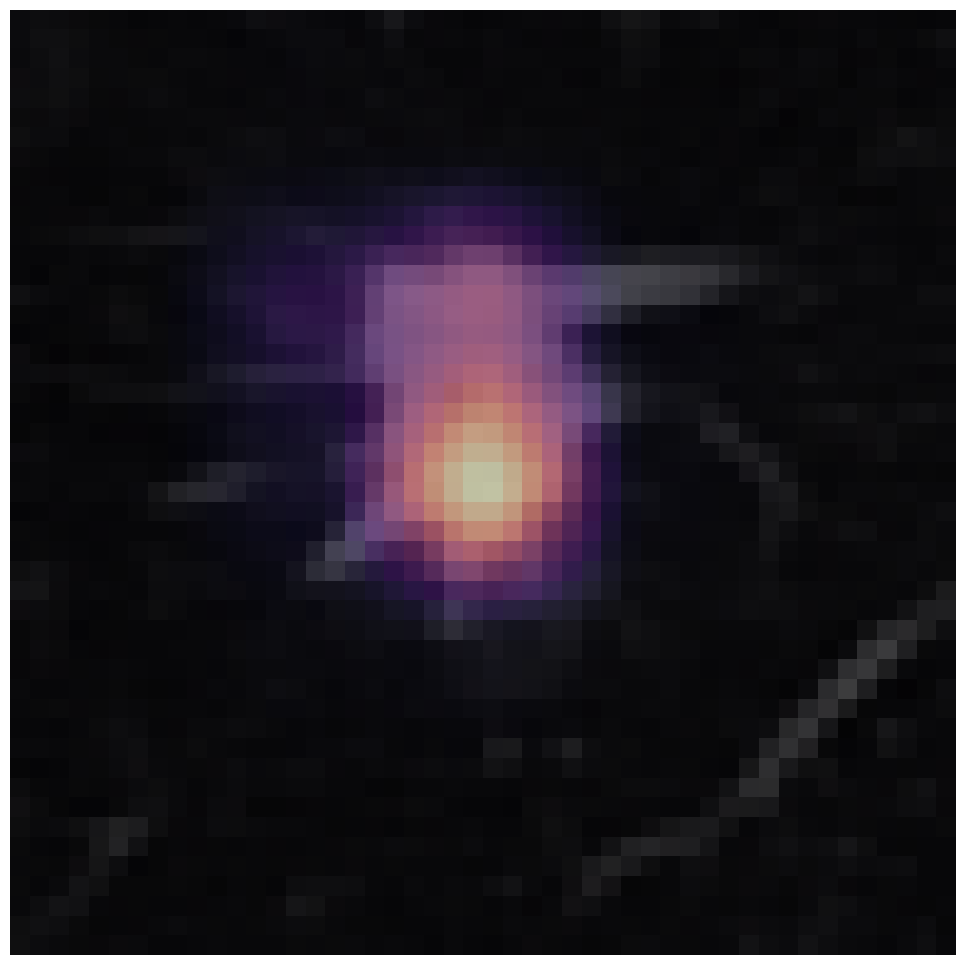

torch.Size([3, 48, 48, 48]) CTFMExtractor


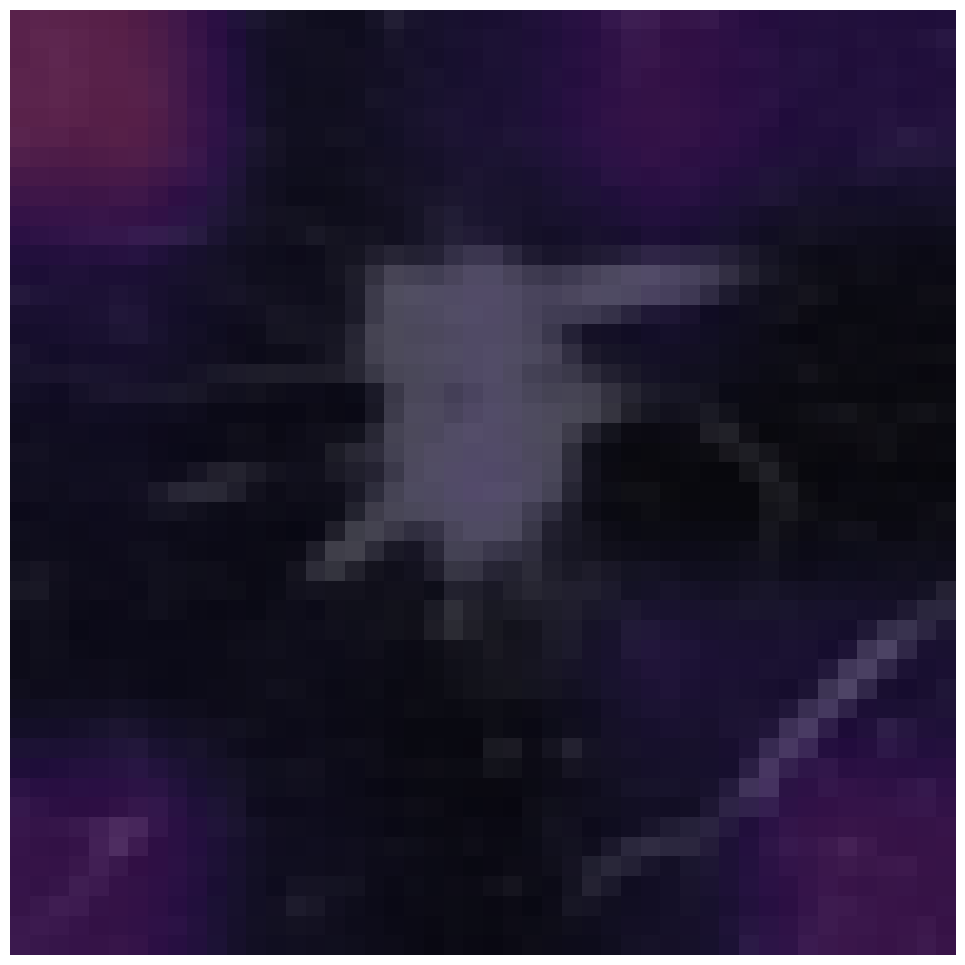

torch.Size([3, 60, 60, 60]) CTClipVitExtractor


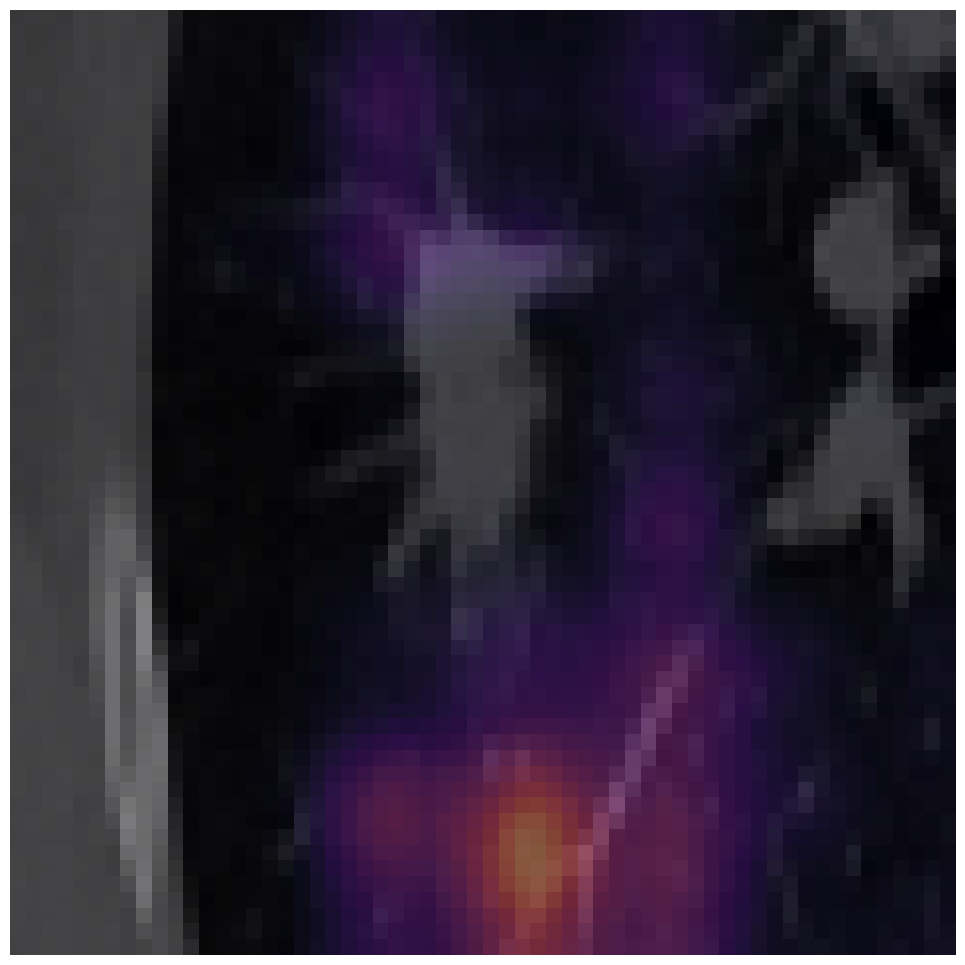

torch.Size([3, 48, 48, 48]) PASTAExtractor


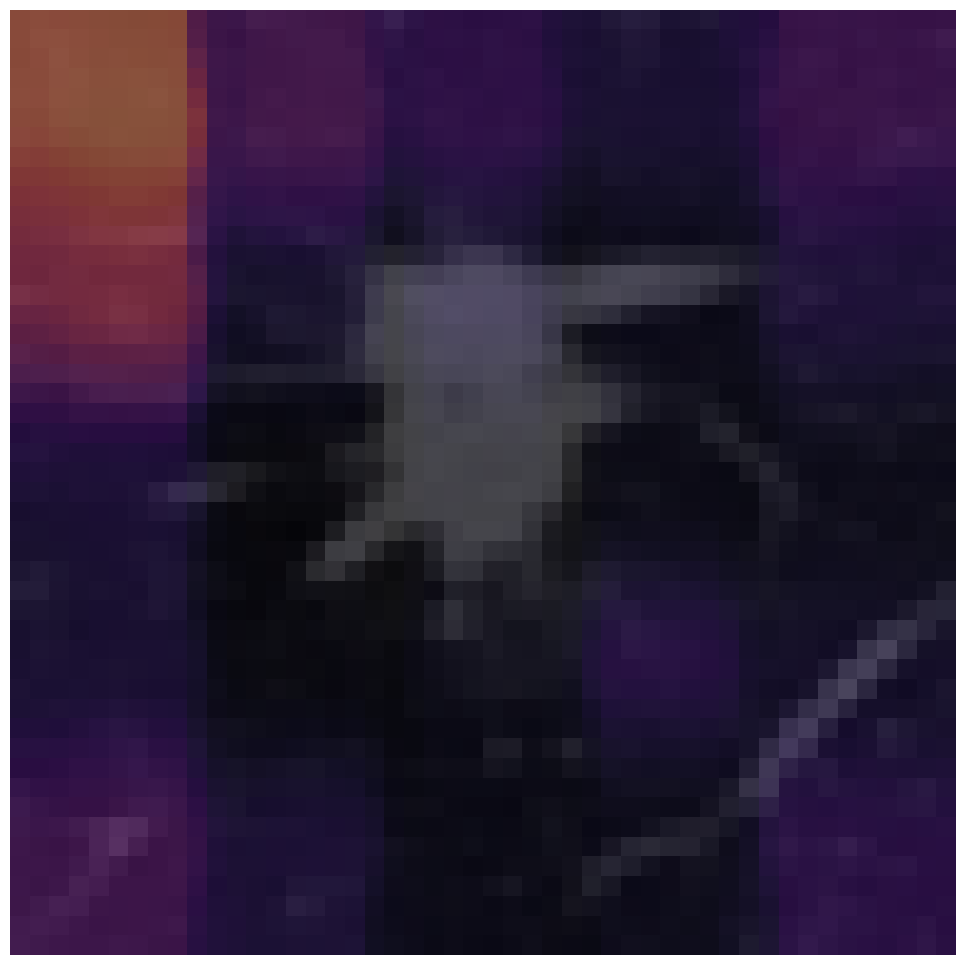

torch.Size([3, 48, 48, 48]) VISTA3DExtractor


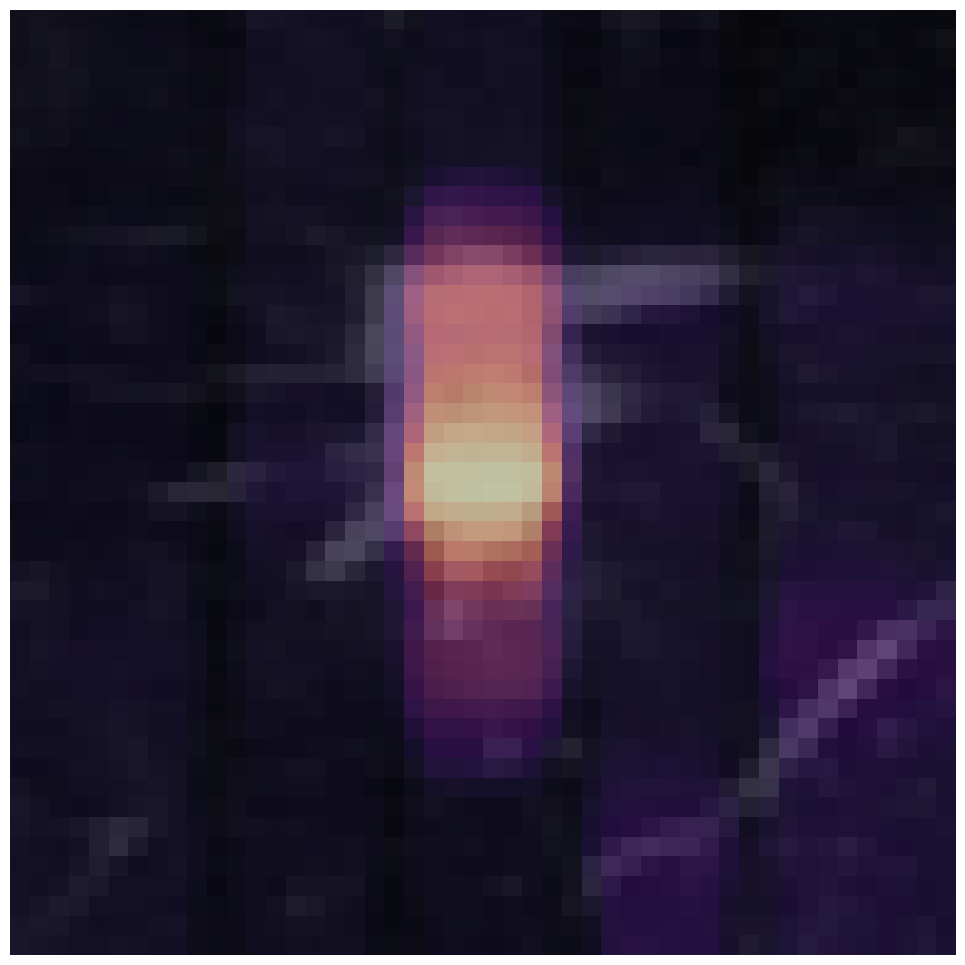

torch.Size([3, 64, 64, 64]) VocoExtractor


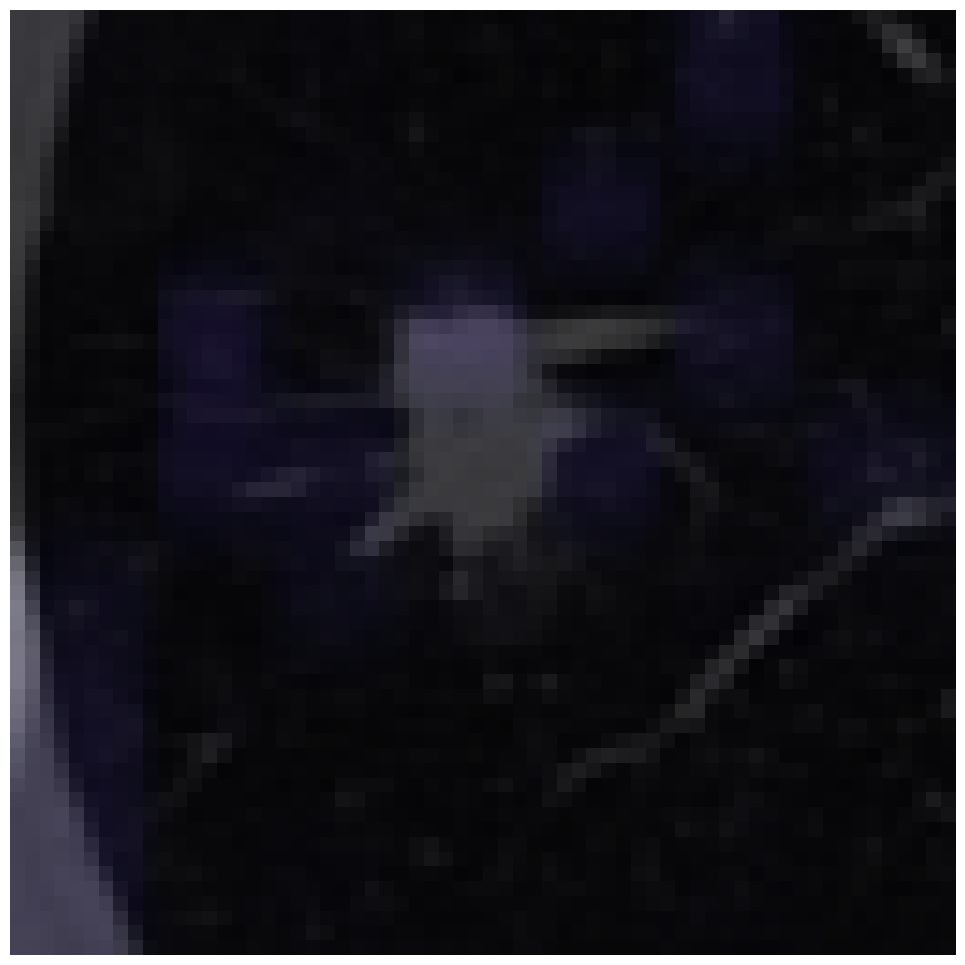

torch.Size([3, 48, 48, 48]) SUPREMExtractor


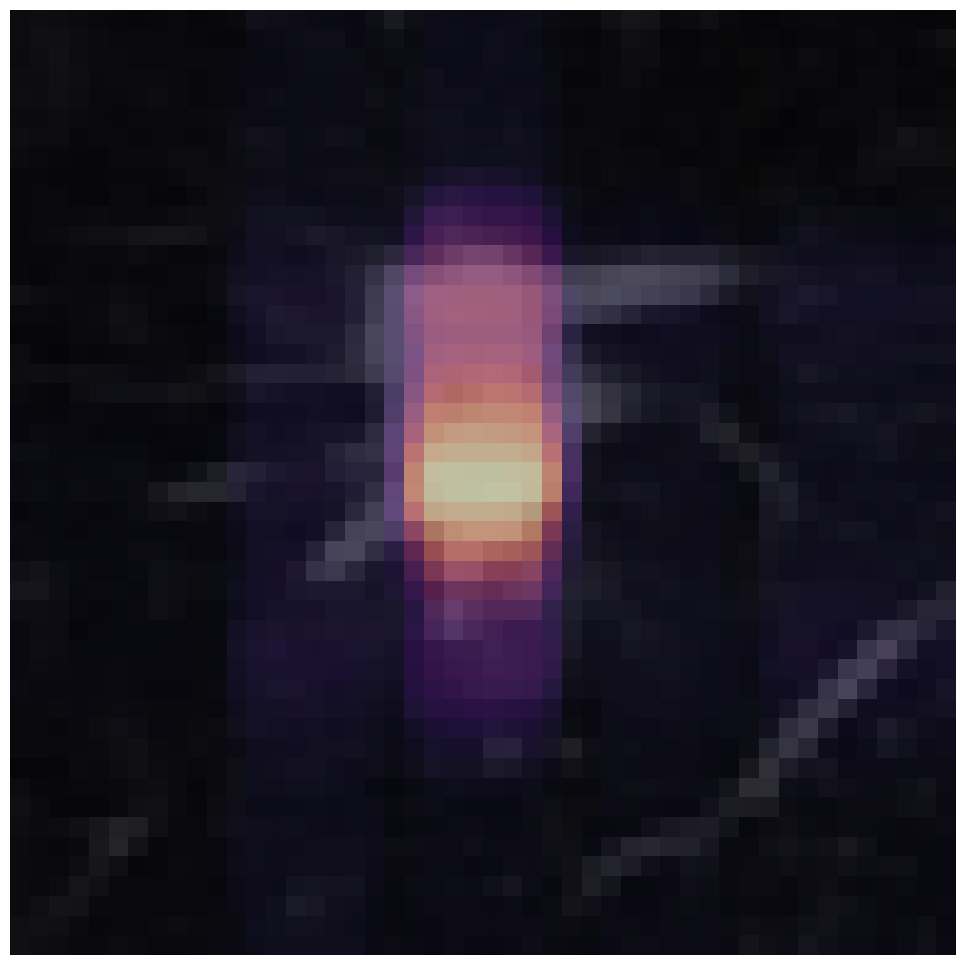

torch.Size([3, 48, 48, 48]) MerlinExtractor


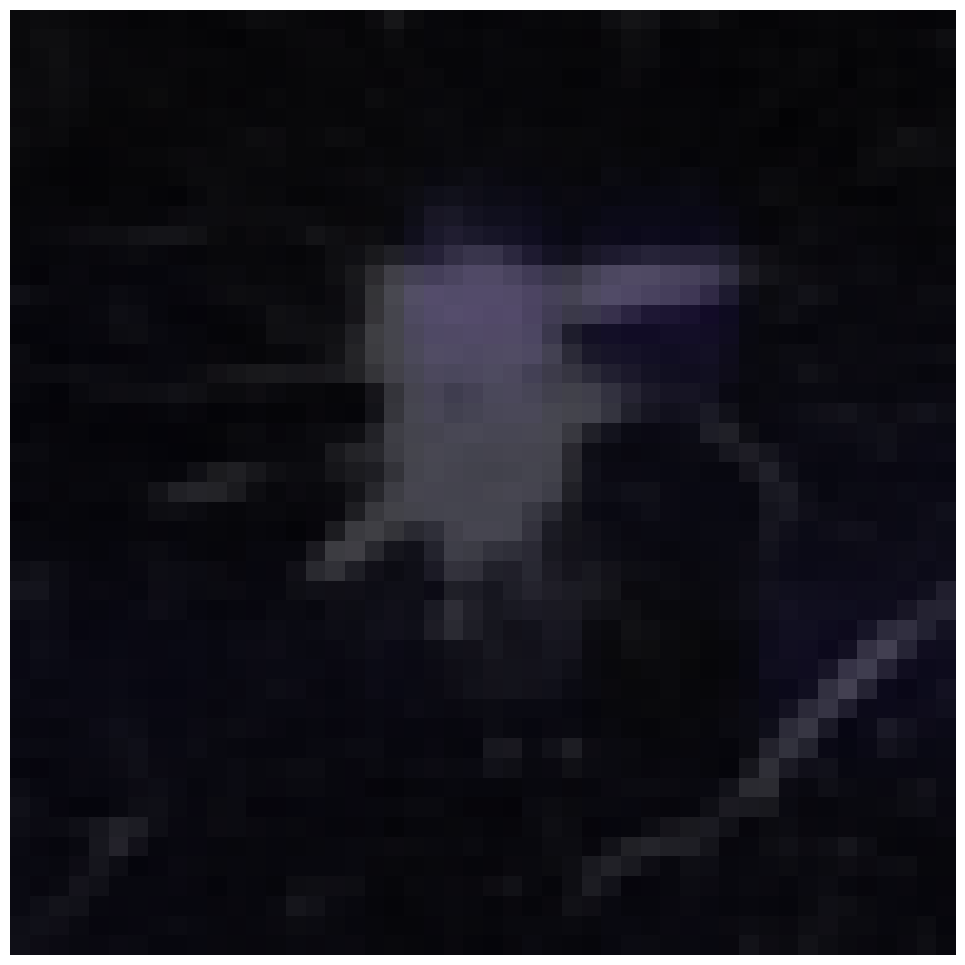

torch.Size([3, 48, 48, 48]) ModelsGenExtractor


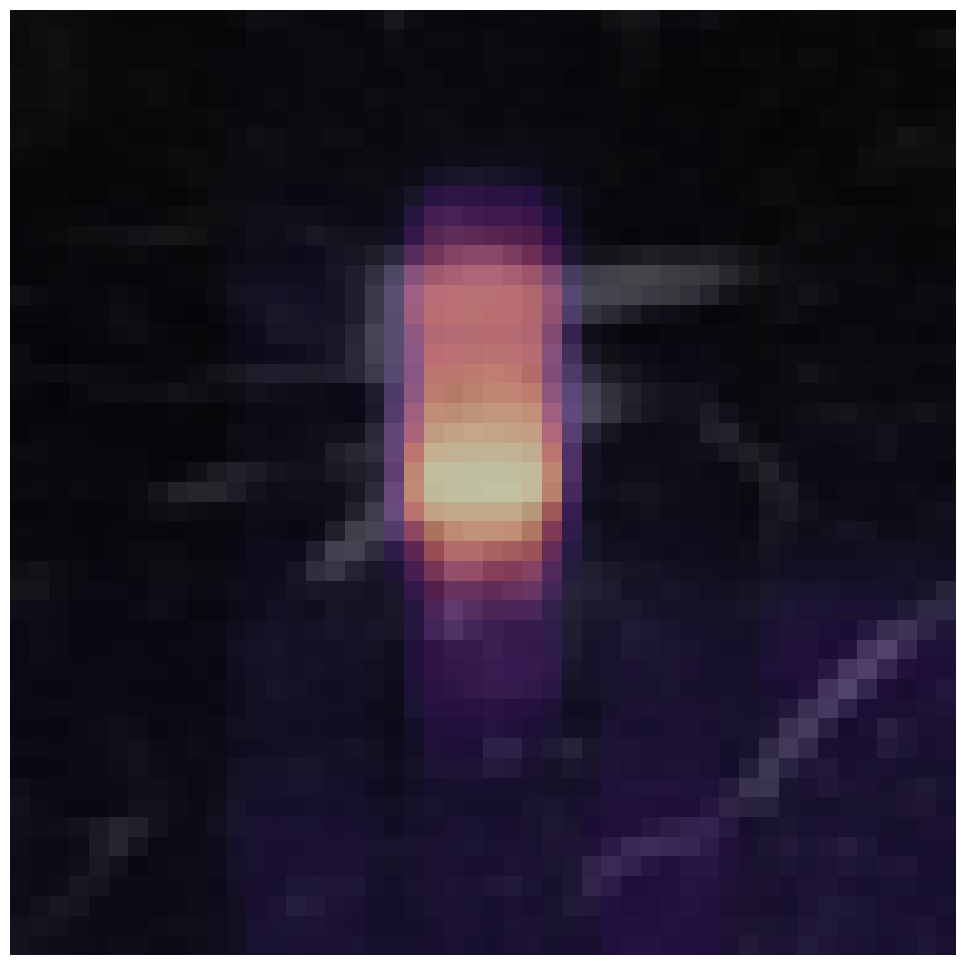

In [124]:
data_subset = [item for item in data_list if (item["dataset"] == "NSCLC_Radiogenomics") and (item["index"] == 0)]

visuals = []

model_order = [
    "FMCIBExtractor",
    "CTFMExtractor",
    "CTClipVitExtractor",
    "PASTAExtractor",
    "VISTA3DExtractor",
    "VocoExtractor",
    "SUPREMExtractor",
    "MerlinExtractor",
    "MedImageInsightExtractor",
    "ModelsGenExtractor",
]

def get_model_priority(model_name):
    try:
        return model_order.index(model_name)
    except ValueError:
        return float('inf')

data_subset = sorted(data_subset, key=lambda item: get_model_priority(item["model"]))

for row in data_subset:
    # distance = torch.exp(distance / 100)
    x = row["image"]
    distance = row["distance_map"]
    x = x.cpu()
    distance = distance.cpu()
    distance = torchvision.transforms.GaussianBlur(kernel_size=7, sigma=4.0)(distance.unsqueeze(0)).squeeze(0)
    ret = blend_images(x[0].flip(1), distance.unsqueeze(0).flip(1), cmap="magma", alpha=0.5)
    print(ret.shape, row["model"])

    if row["model"] == "PASTAExtractor":
        ret = ret.permute(0, 3, 2, 1)
        ret = ret.flip(1, 3)
    if row["model"] == "VocoExtractor":
        ret = ret.permute(0, 3, 2, 1)
        ret = ret.flip(1, 2)       
    if row["model"] == "CTClipVitExtractor":
        ret = ret.permute(0, 1, 3, 2)
    if row["model"] == "MerlinExtractor" or row["model"] == "VISTA3DExtractor" or row["model"] == "SUPREMExtractor" or row["model"] == "ModelsGenExtractor":
        ret = ret.permute(0, 3, 2, 1)  
        ret = ret.flip(1, 2) 
    plot_3d_image(ret, cut=(ret.shape[1]//2, ret.shape[2]//2, ret.shape[3]//2))